In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import measures

np.random.seed(0)

In [2]:
df = pd.read_csv("./../out.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
df = df.loc[400:1400] # first 1000 segments
df = df.reset_index().drop('index', axis=1)
df

,segment,label
0,obstin bigot offici set defianc liber initi go...,c
1,ask thing and proper repli must given It said ...,c
2,co-oper attempt dethron but influenc act parli...,c
3,busi necessari parliament elect execut cours f...,c
4,behind treasuri bench nay possibl rise man sit...,c
...,...,...
995,lamb chop fri tomato potato la crãªme rais bis...,g
996,glass rhine wine IV glass water V glass champa...,g
997,cover cloth set away cool place hour dinner ti...,g
998,transpar veil egg cook white firm lift griddl ...,g


In [4]:
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim import models

documents = df['segment'].tolist()


doc_tokenized = [simple_preprocess(doc, min_len=1, max_len=2000) for doc in documents]
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

In [5]:
# display word and occurence
tfidf_doc_0 = BoW_corpus[0]
for i in range(0, len(tfidf_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(tfidf_doc_0[i][0], dictionary[tfidf_doc_0[i][0]], tfidf_doc_0[i][1]))

Word 0 ("a") appears 2 time.
Word 1 ("achiev") appears 1 time.
Word 2 ("afterward") appears 1 time.
Word 3 ("anoth") appears 1 time.
Word 4 ("appli") appears 1 time.
Word 5 ("arm") appears 1 time.
Word 6 ("attach") appears 1 time.
Word 7 ("backstair") appears 1 time.
Word 8 ("best") appears 1 time.
Word 9 ("bigot") appears 1 time.
Word 10 ("bodi") appears 1 time.
Word 11 ("bring") appears 2 time.
Word 12 ("brought") appears 1 time.
Word 13 ("bureaucraci") appears 2 time.
Word 14 ("bureaucrat") appears 1 time.
Word 15 ("burk") appears 1 time.
Word 16 ("busi") appears 3 time.
Word 17 ("but") appears 1 time.
Word 18 ("cap") appears 1 time.
Word 19 ("care") appears 1 time.
Word 20 ("changeabl") appears 1 time.
Word 21 ("citizen") appears 1 time.
Word 22 ("cloth") appears 1 time.
Word 23 ("colour") appears 1 time.
Word 24 ("come") appears 1 time.
Word 25 ("conflict") appears 1 time.
Word 26 ("cut") appears 1 time.
Word 27 ("danger") appears 1 time.
Word 28 ("defect") appears 3 time.
Word 29

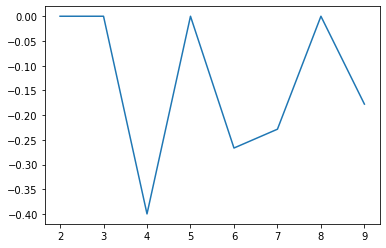

In [6]:
result_num_topic = measures.best_num_topic(corpus_tfidf, dictionary ,10)
# check get_coherence_per_topic()

,topic,score
0,2,0.412759
1,3,0.504164
2,4,0.574045
3,5,0.584414
4,6,0.544864
5,7,0.541012
6,8,0.543975
7,9,0.521637
8,10,0.504344
9,11,0.506217


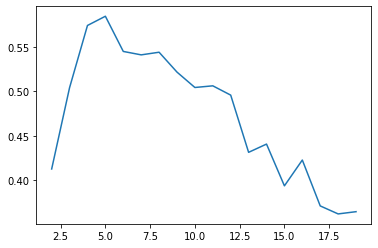

In [7]:
results = measures.best_silhouette_score(model = KMeans(), corpus = corpus_tfidf, dictionary = dictionary , max_n_clusters = 20, best_num_topic=5)
results

In [8]:
best_at = list(results['score']).index(results['score'].max())+2
print("Peak at k={}, silhouette_score = {}".format(best_at, results['score'].max()))

Peak at k=5, silhouette_score = 0.5844141185054668


In [9]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=best_at)
corpus_lsi = lsi_model[corpus_tfidf] 

cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
cm.get_coherence()


0.0

In [10]:
for doc, as_text in zip(corpus_lsi, documents):
    print(doc, as_text)

[(0, -0.1554613604103785), (1, 0.0034519002200642185), (2, -0.061116012012454), (3, -0.1390911280847215), (4, 0.047023090279001)] obstin bigot offici set defianc liber initi govern trust backstair influenc second easi method bring justic guilti offici present franc conflict simpl citizen like men arm cap-a-pi fight defenceless A system intellig nativ liber bring even colour reason grave object danger model foreign imit the defect bureaucraci inde well known It form govern tri often enough world easi show human natur long run defect bureaucraci must long run It inevit defect bureaucrat care routin result burk put think substanc busi much import form their whole educ habit life make they brought young particular part public servic attach occupi year learn form afterward year appli form trifl matter they use phrase old writer tailor busi cut cloth find bodi men train must come think routin busi mean end imagin elabor machineri form part deriv digniti grand achiev result work changeabl ins

In [11]:
[[tup[1] for tup in arr] for arr in corpus_lsi]

[[-0.1554613604103785,
  0.0034519002200642185,
  -0.061116012012454,
  -0.1390911280847215,
  0.047023090279001],
 [-0.13352566669103316,
  0.01352565816205436,
  -0.06990908751043819,
  -0.174227830091386,
  0.0616458538596044],
 [-0.17897260237610918,
  0.014080728427442986,
  -0.095520091247527,
  -0.22961411069861218,
  0.11619890143799984],
 [-0.1445699023596537,
  0.011361217074968665,
  -0.06267784806868079,
  -0.18947316619517415,
  0.09722326301135509],
 [-0.13539595435283228,
  0.00032496076189530575,
  -0.057517330139886566,
  -0.16871570080283693,
  0.07818815192919726],
 [-0.15090923566675923,
  -0.002693483727694337,
  -0.06015707869138363,
  -0.1485940530383846,
  0.046854697303508955],
 [-0.11895714025640175,
  0.01597489051627643,
  -0.051880890280489096,
  -0.13606330569865197,
  0.054617296432655],
 [-0.1345658786859763,
  0.023858577147923693,
  -0.04357564997803839,
  -0.14658796048321587,
  0.027057489384432178],
 [-0.17222686233707774,
  0.016655456716135726,
  

In [12]:
X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

In [13]:
from gensim.matutils import corpus2csc

corpus_tfidf_sparse = corpus2csc(corpus_tfidf)

kmeans_pred = kmeans.fit_predict(corpus_tfidf_sparse.T)

In [14]:
from gensim.matutils import corpus2csc
pred_map = dict()
k = 5

for i in range(0, 5):
    count = np.bincount(kmeans_pred[i * 200 : i * 200 + 200])
    np.ndarray.resize(count, (1,k))
    count = count[0]
    index = np.where(count == max(count))[0][0]
    label = chr(ord('c')+i)
    pred_map[index] = label
    print(label + ":" + np.array2string(count) + "\t" + label + " mapped to " + str(index))

c:[  0   4   0 196   0]	c mapped to 3
d:[  0 200   0   0   0]	d mapped to 1
e:[200   0   0   0   0]	e mapped to 0
f:[  0   3   0   0 197]	f mapped to 4
g:[  0   9 191   0   0]	g mapped to 2


In [15]:
mapped_pred = []
for ele in kmeans_pred:
    mapped_pred.append(pred_map[ele])
mapped_pred = np.asarray(mapped_pred) # predicted label

In [16]:
kappa = measures.get_kappa(df['label'], mapped_pred)
rand_score = measures.get_rand_score(df['label'], mapped_pred)
silhouette = measures.get_silhouette_score(corpus_lsi, kmeans_pred)
coherence = measures.get_coherence(cm)

kappa: 0.98
rand score: 0.9600610150924449
silhouette score: 0.5340391262652369
coherence: 0.0


C:\Users\zwang684\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


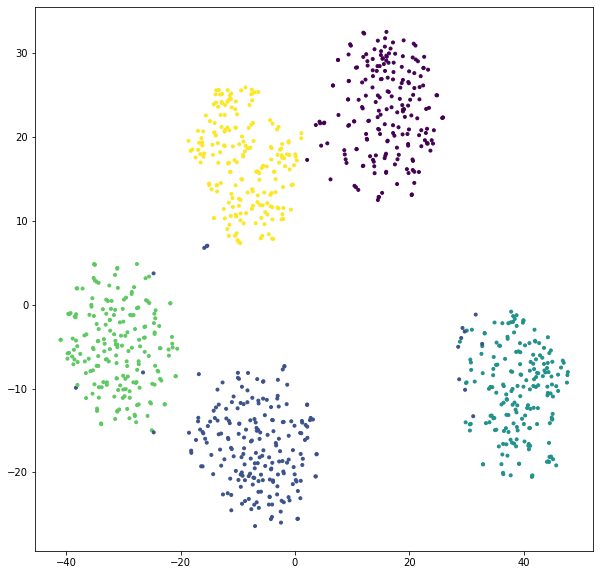

In [17]:
from sklearn.manifold import TSNE

tfidf_embedded = TSNE(n_components=2, 
                    perplexity=50, 
                    learning_rate = 'auto',
                    n_iter=1000, 
                    random_state=0).fit_transform(corpus_tfidf_sparse.T) #corpus_tfidf_sparse.T

fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfidf_embedded[:, 0], tfidf_embedded[:, 1], marker = ".", c = kmeans_pred)
plt.show()